Code for the paper "Understanding Filter Bubbles and Polarization in Social Networks" by Uthsav Chitra and Chris Musco.

Link: https://arxiv.org/pdf/1906.08772.pdf


All code is run using Python 3.
Dependencies: 
* Numpy version 1.16.3
* Matplotlib version 3.0.3
* Scipy version 1.2.1
* NetworkX version 2.3
* Gurobi version 8.1.1 [Note: Gurobi needs a license to be run, but this license is free for academics]

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

from scipy.linalg import solve
from gurobipy import *

import networkx as nx

from time import time
from pprint import pprint
import pickle
import csv # reading network files

path = 'run_real'

In [35]:
import json

class NADynamics_JSONEncoder(json.JSONEncoder):
    """
    - Serializes python/Numpy objects via customizing json encoder.
    - **Usage**
        - `json.dumps(python_dict, cls=EncodeFromNumpy)` to get json string.
        - `json.dump(*args, cls=EncodeFromNumpy)` to create a file.json.
    """
    def default(self, obj):
        import numpy as np
        if isinstance(obj, np.ndarray):
            return {
                "_kind_": "ndarray",
                "_value_": obj.tolist()
            }
        elif isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            if isinstance(obj, np.float64):
                return {
                "_kind_": "np.float64",
                "_value_": float(obj)
                }
            return float(obj)
        elif isinstance(obj, range):
            value = list(obj)
            return {
                "_kind_" : "range",
                "_value_" : [value[0],value[-1]+1]
            }

        return super(NADynamics_JSONEncoder, self).default(obj)

from typing import Optional, Any, Dict

class NADynamics_JSONDecoder(json.JSONDecoder):
    """
    - Deserilizes JSON object to Python/Numpy's objects.
    - **Usage**
        - `json.loads(json_string,cls=DecodeToNumpy)` from string, use `json.load()` for file.
    """
    def __init__(self, *args, **kwargs):
        json.JSONDecoder.__init__(self, object_hook=self.object_hook, *args, **kwargs)

    @staticmethod
    def object_hook(obj: Optional[(Dict[str, Any])]) -> Any:
        import numpy as np
        if '_kind_' not in obj:
            return obj
        kind = obj['_kind_']
        if kind == 'ndarray':
            return np.array(obj['_value_'], dtype=np.float64)
        elif kind == 'np.float64':
            return np.float64(obj)
        elif kind == 'range':
            value = obj['_value_']
            return range(value[0], value[-1])
        elif kind == 'tuple':
            return tuple(obj['_value_'])
        return obj

import json

def save_na_run(rd_dict, filename):
    with open(filename, 'w') as fd_write:
        json.dump(rd_dict, fd_write, cls=NADynamics_JSONEncoder)

def load_na_run(filename):
    rd_dict = {}
    with open(filename, 'r') as fd_read:
        rd_load = json.load(fd_read, cls=NADynamics_JSONDecoder)
        for key in rd_load.keys():
            fl_key = float(key)
            rd_dict[fl_key] = rd_load[key]
            rd_dict[fl_key][0] = [np.float64(x) for x in rd_load[key][0]]
            rd_dict[fl_key][1] = [np.float64(x) for x in rd_load[key][1]]
            rd_dict[fl_key] = tuple(rd_dict[fl_key])

    return rd_dict

# Alternating Minimization/SBM Code

Below: code for generating a Stochastic Block Model (SBM) graph with two groups (Section 4.1)

In [2]:
# q0: edge probability in group 0
# q1: edge probability in group 1
# p: edge probability in between groups

# intrinsic opinions in group i are drawn iid from N(si_mean, s_std)
# group 0 has n nodes, group 1 has m nodes
def create_A_s(q0,q1,p, s0_mean=0.25, s1_mean=0.75, s_std=0.1,n=32,m=32,lb=0,ub=1):
    tot = n+m

    A = np.zeros([tot,tot])
    for i in range(tot):
        for j in range(i+1,tot):
            if i > n and j > n: #q1
                A[i,j]=np.random.binomial(1,q1)
            elif j > n: # then i <=n-1 and j > n, so p
                A[i,j]=np.random.binomial(1,p)
            elif j <=n: # then i <= n-1 and j <= n-1, so q0
                A[i,j]=np.random.binomial(1,q0)
    A=A+A.T
    s = np.concatenate((np.random.normal(loc=s0_mean,scale=s_std,size=n),np.random.normal(loc=s1_mean,scale=s_std,size=m)))
    s=np.maximum(s,lb)
    s=np.minimum(s,ub)
    return A,s

Next, we create our "alternating minimization" function, which simulates the Network Administrator Dynamics (Section 3)

In [3]:
################################################
# HELPER FUNCTIONS FOR ALTERNATING MINIMIZATION
################################################

# find z that minimizes z^T L z + |z-s|^2
# W = weight matrix for graph
# s = innate opinions
def min_z(W,s):
    D = np.diag(np.sum(W,0))
    L = D - W
    n=L.shape[0]
    return solve(L+np.eye(n),s)

# find weight matrix W that minimizes z^T L z, 
# where L is graph Laplacian corresponding to W
# constrained to {W : ||W-W0|| < lam * ||W0||} where W0 is the original graph
# (lam is what proportio of edges in the original graph you are allowed to change)
# we also impose the restriction that sum(W[:,i]) = sum(W0[:,i]), 
# i.e. the degree of each vertex is conserved

# IF reduce_pls = True, then we add the term gam*||W||^2 to the objective
# as this empirically reduces polarization (encourages more connections to every vertex)
def min_w_gurobi(z, lam, W0, reduce_pls, gam, existing):
    n = z.shape[0]
    m = Model("qcp")

    if existing:
        inds = [(i,j) for i in range(n) for j in range(n) if i>j and W0[i,j] > 0]
    else:
        inds = [(i,j) for i in range(n) for j in range(n) if i>j]
    x=m.addVars(inds, lb=0.0, name="x")

    # obj is min \sum_{i,j} wij (zi-zj)^2
    if existing:
        w={(i,j):(z[i]-z[j])**2 for i in range(n) for j in range(n) if i>j and W0[i,j]>0}
    else:
        w = {(i,j):(z[i]-z[j])**2 for i in range(n) for j in range(n) if i>j}

    obj_exp = x.prod(w)
    if reduce_pls:
        obj_exp += gam*x.prod(x)
    m.setObjective(obj_exp, GRB.MINIMIZE)
    print('added variables')
    
    # add constraints sum_j x[i,j] = di
    d = np.sum(W0,0)
    for i in range(n):
        if existing:
            m.addConstr(quicksum([x[(j,i)] for j in range(i+1,n) if W0[i,j] > 0] + [x[(i,j)] for j in range(i) if W0[i,j] > 0]) == d[i])
        else:
            m.addConstr(quicksum([x[(j,i)] for j in range(i+1,n)] + [x[(i,j)] for j in range(i)]) == d[i])
    print('added first constraint')
    
    # add constraint \sum_{i,j} (wij - w0ij) < lam*norm(w0)**2
    rhs = (lam*np.linalg.norm(A))**2
    
    if existing:
        m.addQConstr(quicksum([x[(i,j)]*x[(i,j)]-2*x[(i,j)]*W0[i,j]+W0[i,j]*W0[i,j] for i in range(n) for j in range(n) if i>j and W0[i,j] > 0]) <= rhs)
    else:
        m.addQConstr(quicksum([x[(i,j)]*x[(i,j)]-2*x[(i,j)]*W0[i,j]+W0[i,j]*W0[i,j] for i in range(n) for j in range(n) if i>j]) <= rhs)
    print('added second constraint')
    print('starting to optimize')
    m.optimize()
    
    W = np.zeros([n,n])
    for u in range(n):
        for v in range(n):
            if u>v:
                if (existing and W0[u,v] > 0) or (not existing):
                    W[u,v]=x[(u,v)].X
                    W[v,u] = W[u,v]
    return W

# given opinion vectors z, compute 
# polarization = variance(z)
def compute_pls(z):
    z_centered = z - np.mean(z)
    return z_centered.dot(z_centered)

In [4]:
# Alternating Minimization function for network admin game
# Parameters:
# 1) A: initial graph (adjacency matrix) 

# 2) s: intrinsic opinions

# 3) lam: constraint parameter

# 4) reduce_pls: if true, implement additional L2 regularization to 
# reduce polarization (and disagreement!)
# 5) gam: regularization coefficient for reduce_pls
# 6) max_iters: max number of iterations of network admin game

# 7) existing: only change weights of edges already existing in the graph 

# RETURNS:
# pls: list of polarizations at each iteration
# z: opinions at final iteration of game
# W: adjacency matrix at final iteration of game
def am(A,s,lam,reduce_pls=False,gam=0,max_iters=100, existing=False):
    # alternating minimization
    W = np.copy(A)
    z = min_z(W,s) # minimize z first

    # polarization
    pls = [compute_pls(z)]
    
    # disagreement
    L = np.diag(np.sum(W,0))-W
    disaggs = [z.T.dot(L).dot(z)]

    # LOOP: first minimize W, then minimize z
    # then decide if we should exit
    i = 0
    flag = True
    while flag:
        print('iteration: {}'.format(i))
        # minimize W
        Wnew = min_w_gurobi(z,lam,A,reduce_pls=reduce_pls,gam=gam,existing=existing)
        
        # minimize z
        znew = min_z(Wnew,s)

        # exit condition
        if np.maximum(np.linalg.norm(z-znew), np.linalg.norm(Wnew-W)) < 5e-1 or i > max_iters - 1:
            flag = False

        # update z,W,i,pls
        z = znew
        W = Wnew
        i=i+1
        pls.append(compute_pls(z))
        L = np.diag(np.sum(W,0))-W
        disaggs.append(z.T.dot(L).dot(z))
    return pls, disaggs, z, W

# Creating Teaser Image (Figure 1)

In this section, we create the images used in Figure 1.
Note: If you re-run this code, you will likely create an image that looks different than Figure 1, because of the randomness in the SBM graph (and also I'm not sure how networkx draws graphs).

## Create SBM network and run NA dynamics

In [5]:
q0=0.25
q1=0.25
p=0.1
n=20
m=20

# create SBM network
A,s=create_A_s(q0,q1,p, s0_mean=-0.7, s1_mean=0.7, s_std=0.1,n=n,m=m,lb=-1.0,ub=1.0)

# run the network administrator (NA) dynamics on A, 
# with varying amounts of constraints on NA
pls1,objs1,z1,W1=am(A,s,0.14)
pls2,objs2,z2,W2=am(A,s,0.2)
pls3,objs3,z3,W3=am(A,s,0.3) # ended up not using this one

W1=np.round(W1,decimals=3)
W2=np.round(W2,decimals=3)
W3=np.round(W3,decimals=3)

LA = np.diag(np.sum(A,0))-A
z_before=solve(LA+np.eye(n+m),s)

iteration: 0
Academic license - for non-commercial use only - expires 2021-06-06
Using license file C:\Users\GGM\gurobi.lic
added variables
added first constraint
added second constraint
starting to optimize
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 40 rows, 780 columns and 1560 nonzeros
Model fingerprint: 0xf6074133
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [2e-10, 4e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 1e+01]
  QRHS range       [1e+02, 1e+02]
Presolve time: 0.03s
Presolved: 822 rows, 782 columns, 2478 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 3.338e+03
 Factor NZ  : 4.161e+03 (roughly 1 MByte of memory)
 Factor Ops : 3.929e+

## Functions for graph visualization

A bunch of scripts for visualizing our graphs so that:

1) edges are lighter/darker depending on their weight

2) nodes are colored depending on their expressed opinion

In [6]:
def vis_params(W,z,layout='spring'):
    G = nx.Graph(W)
    
    if layout == 'spectral':
        pos=nx.spectral_layout(G)
    else:
        pos = nx.spring_layout(G)
        
    edge_colors = np.zeros(len(G.edges))
    i=0
    for edge in G.edges():
        u,v=edge
        edge_colors[i]=W[u,v]
        i+=1

    node_colors = np.zeros(len(G.nodes))
    i=0
    for n in G.nodes():
        node_colors[i]=z[i]
        i+=1
    return G, pos, edge_colors, node_colors

def plot_graph(G, pos, node_colors, edge_colors, emin, emax, vmin, vmax,width=0.5,node_size=150):
    nx.draw(G, pos, node_size=node_size, node_color=node_colors, cmap=plt.cm.coolwarm, vmin=vmin,vmax=vmax, width=width, edge_color=edge_colors, edge_cmap=plt.cm.binary, edge_vmin=emin, edge_vmax=emax)

Ga, posa, edge_colors_a, node_colors_a = vis_params(A, z_before)
G1, pos1, edge_colors_1, node_colors_1 = vis_params(W1, z1)
G2, pos2, edge_colors_2, node_colors_2 = vis_params(W2, z2)
G3, pos3, edge_colors_3, node_colors_3 = vis_params(W3, z3)

# set scale for edges
# we want weight emax to be the darkest edge, and 0.0 to be the lightest edge
emin=0.2
emax=1.0

# set scale for vertices
# we want 1.0 to be reddest vertex, 0.0 to be bluest vertex
vmin1=-1.0
vmax1=1.0

vmin2=np.min(z2)
vmax2=np.max(z2)

## Check how much NA changed graphs

Check what % of edge weight in W1 and W2 is changed by the NA

In [7]:
np.linalg.norm(W1-A,1) /np.linalg.norm(A,1) # about 20% is changed

0.23809999999999998

In [8]:
np.linalg.norm(W2-A,1) /np.linalg.norm(A,1) # about 30% is changed

0.3476000000000001

## Create plots used in teaser figure 

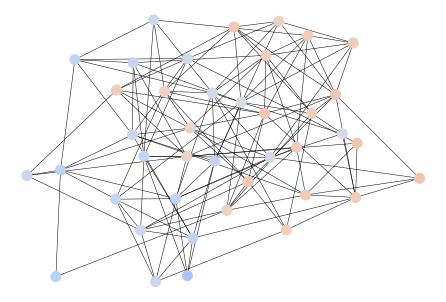

In [9]:
plot_graph(Ga, posa, node_colors_a, edge_colors_a, emin, emax, vmin1, vmax1,node_size=100)
plt.savefig(f'{path}/potential_teaser4a_2.png')

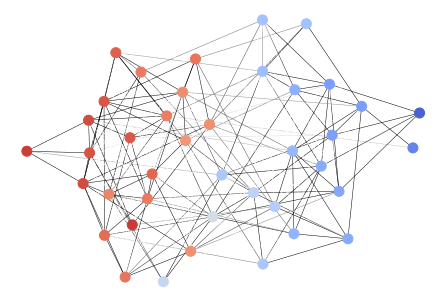

In [10]:
plot_graph(G1, pos1, node_colors_1, edge_colors_1, emin, emax, vmin2, vmax2,node_size=100)
plt.savefig(f'{path}/potential_teaser4b_2.png')

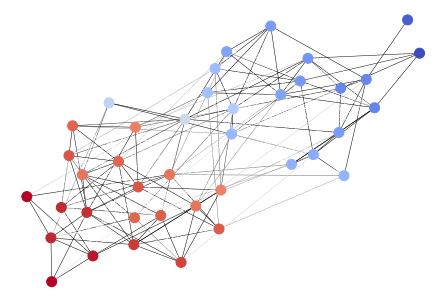

In [11]:
plot_graph(G2, pos2, node_colors_2, edge_colors_2, emin, emax, vmin2, vmax2,node_size=100)
plt.savefig(f'{path}/potential_teaser4c_2.png')

# Working with real networks (Figure 2, Figure 4)

Below is the code for Figure 2 and Figure 4 in the paper. For two networks (Reddit and Twitter) we run:

1) Network Administrator Dynamics (Section 3)    
2) Regularized Network Administrator Dynamics (Section 5)

For details on the datasets, see Section 3.2.

## Reddit

### Load network, opinions

In [12]:
# load adjacency matrix
n_reddit=556
A = np.zeros([n_reddit, n_reddit])
z_dict={i:[] for i in range(n_reddit)}

with open('Reddit/edges_reddit.txt','r') as f:
    reader=csv.reader(f,delimiter='\t')
    for u,v in reader:
        A[int(u)-1,int(v)-1] += 1
        A[int(v)-1,int(u)-1] += 1

# load opinions
with open('Reddit/reddit_opinion.txt','r') as f:
    reader=csv.reader(f,delimiter='\t')
    for u,v,w in reader:
        z_dict[int(u)-1].append(float(w))

# remove nodes not connected in graph
not_connected = np.argwhere(np.sum(A,0)==0)
A=np.delete(A,not_connected,axis=0)
A=np.delete(A,not_connected,axis=1)
n_reddit = n_reddit-len(not_connected)

# create z (avg-ing posts)
z = [np.mean(z_dict[i]) for i in range(n_reddit)]
z=np.array(z)

# create innate opinions from z (i.e. s=(L+I)*z)
L = np.diag(np.sum(A,0)) - A
s = (L+np.eye(n_reddit)).dot(z)
s=np.minimum(np.maximum(s,0),1)

### Run NA dynamics

We run the Network Administrator Dynamics on the Reddit network, both non-regularized (Section 3) and regularized (Section 5).    
NOTE: running the below code will take a couple hours. Be sure to save the results!

In [13]:
# run NA dynamics for lam=[0.1,0.2, ..., 1.0]
# because of time issues, we run the NA dynamics separately 
# for [0.1, ..., 0.5] and [0.6, ..., 1.0]

lam_list = [0.1,0.2,0.3,0.4,0.5]
# results are dicts of the form
# lambda -> (polarization at each iteration, disagreement at each iter, expressed opinions after NA dynamics, adjacency matrix after NA dynamics)

rd={} # results for NA dynamics
rd_fix={} # results for regularized NA dynamics

max_iter=7 # usually converges after 5-10 iterations
gam=0.2 # L2 regularization coefficient
for lam in lam_list:
    print('no fix')
    print('lam: {}'.format(lam))
    pls, disaggs, z, W = am(A,s,lam,reduce_pls=False,gam=0,max_iters=max_iter)
    print('with fix')
    print('lam: {}'.format(lam))
    pls2, disaggs2, z2, W2 = am(A,s,lam,reduce_pls=True,gam=gam,max_iters=max_iter)
    
    rd[lam] = (pls,disaggs,z,W)
    rd_fix[lam] = (pls2,disaggs2,z2,W2)

no fix
lam: 0.1
iteration: 0
added variables
added first constraint
added second constraint
starting to optimize
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 553 rows, 152628 columns and 305256 nonzeros
Model fingerprint: 0xb7294729
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 8e+00]
  Objective range  [6e-15, 2e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+01]
  QRHS range       [1e+04, 1e+04]
Presolve time: 0.30s
Presolved: 153183 rows, 152630 columns, 466856 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.11s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 6.206e+05
 Factor NZ  : 7.738e+05 (roughly 130 MBytes of memory)
 Factor Ops : 5.966e+07 (less than 1 second per iteration)
 Threads    : 4

                  Objec

In [33]:
fname_reddit = f'{path}/reddit.json'
fname_reddit_fix = f'{path}/reddit_fix.json'

save_na_run(rd, fname_reddit)
save_na_run(rd_fix, fname_reddit_fix)

rd1 = load_na_run(fname_reddit)
rd2 = load_na_run(fname_reddit_fix)

# from deepdiff import DeepDiff
# diff2 = DeepDiff(rd1, rd)


In [34]:
lam_list = [0.6,0.7,0.8,0.9,1.0]
rd_large={}
rd_large_fix={}

max_iter=7
gam=0.2
for lam in lam_list:
    print('no fix')
    print('lam: {}'.format(lam))
    pls, disaggs, z, W = am(A,s,lam,reduce_pls=False,gam=0,max_iters=max_iter)
    print('with fix')
    print('lam: {}'.format(lam))
    pls2, disaggs2, z2, W2 = am(A,s,lam,reduce_pls=True,gam=gam,max_iters=max_iter)
    
    rd_large[lam] = (pls,disaggs,z,W)
    rd_large_fix[lam] = (pls2,disaggs2,z2,W2)

no fix
lam: 0.6
iteration: 0
added variables
added first constraint
added second constraint
starting to optimize
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 553 rows, 152628 columns and 305256 nonzeros
Model fingerprint: 0x4e6c5daa
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 8e+00]
  Objective range  [6e-15, 2e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+01]
  QRHS range       [3e+03, 3e+03]
Presolve time: 0.32s
Presolved: 153183 rows, 152630 columns, 466856 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.12s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 6.206e+05
 Factor NZ  : 7.738e+05 (roughly 130 MBytes of memory)
 Factor Ops : 5.966e+07 (less than 1 second per iteration)
 Threads    : 4

                  Objec

### Analyze results

Below: an example entry of the results

In [36]:
# merge results
rd_reddit = {}
rd_reddit.update(rd)
rd_reddit.update(rd_large)

rd_reddit_fix = {}
rd_reddit_fix.update(rd_fix)
rd_reddit_fix.update(rd_large_fix)

# save results
fname_reddit = f'{path}/reddit_all.json'
fname_reddit_fix = f'{path}/reddit_all_fix.json'

save_na_run(rd_reddit, fname_reddit)
save_na_run(rd_reddit_fix, fname_reddit_fix)

rd_test1 = load_na_run(fname_reddit)
rd_test2 = load_na_run(fname_reddit_fix)

# from deepdiff import DeepDiff
# diff2 = DeepDiff(rd_reddit, rd_test1)

#### Plot polarization, disagreement without regularization

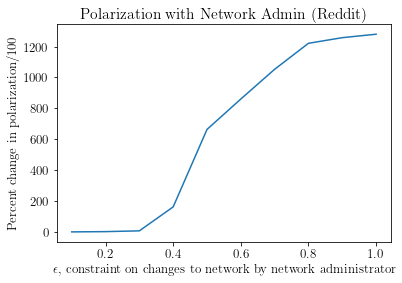

In [37]:
lamvals = sorted(rd_reddit.keys())

pls_after_list=np.zeros(len(lamvals))
pls_ratio_list=np.zeros(len(lamvals))
i=0
for lam in lamvals:
    pls = rd_reddit[lam][0]
    pls_ratio_list[i] = pls[-1] * 1.0 / pls[0]
    pls_after_list[i] = pls[-1]
    i+=1

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 13})

plt.plot(lamvals,pls_ratio_list - 1)
plt.xlabel('$\epsilon$, constraint on changes to network by network administrator')
plt.ylabel('Percent change in polarization/100')
plt.title('Polarization with Network Admin (Reddit)')

plt.savefig(f'{path}/polarization_reddit.png')

# HUGE increase in polarization

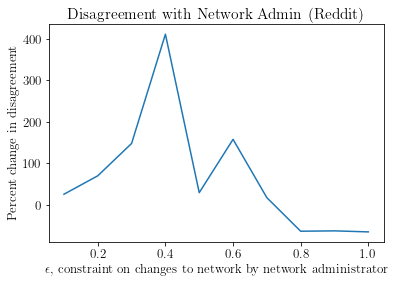

In [38]:
lamvals = sorted(rd_reddit.keys())

disagg_after_list=np.zeros(len(lamvals))
disagg_ratio_list=np.zeros(len(lamvals))
i=0
for lam in lamvals:
    dis = rd_reddit[lam][1]
    disagg_ratio_list[i] = dis[-1] * 1.0 / dis[0]
    disagg_after_list[i] = dis[-1]
    i+=1

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 13})

plt.plot(lamvals,100*(disagg_ratio_list - 1))
plt.xlabel('$\epsilon$, constraint on changes to network by network administrator')
plt.ylabel('Percent change in disagreement')
plt.title('Disagreement with Network Admin (Reddit)')

plt.savefig(f'{path}/disagreement_reddit.png')

# wow, disagreement increases a lot too!

#### Plot polarization, disagreement with regularization

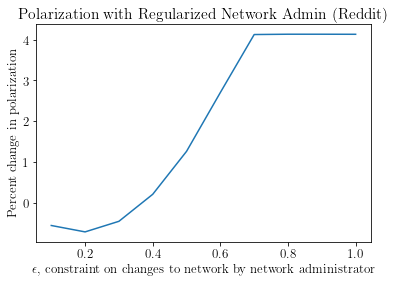

In [39]:
# same plots, but with regularized NA dynamics
lamvals = sorted(rd_reddit_fix.keys())

pls_after_list=np.zeros(len(lamvals))
pls_ratio_list=np.zeros(len(lamvals))
i=0
for lam in lamvals:
    pls = rd_reddit_fix[lam][0]
    pls_ratio_list[i] = pls[-1] * 1.0 / pls[0]
    pls_after_list[i] = pls[-1]
    i+=1

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 13})

plt.plot(lamvals,100*(pls_ratio_list-1))
plt.xlabel('$\epsilon$, constraint on changes to network by network administrator')
plt.ylabel('Percent change in polarization')
plt.title('Polarization with Regularized Network Admin (Reddit)')
    
plt.savefig(f'{path}/polarization_reddit_fix.png')

# polarization is mostly neutral (even slightly dips at lambda=0.2,0.3)

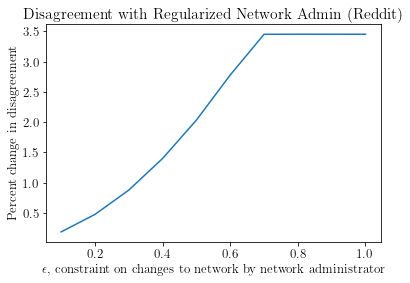

In [40]:
lamvals = sorted(rd_reddit_fix.keys())

disagg_after_list=np.zeros(len(lamvals))
disagg_ratio_list=np.zeros(len(lamvals))
i=0
for lam in lamvals:
    dis = rd_reddit_fix[lam][1]
    disagg_ratio_list[i] = dis[-1] * 1.0 / dis[0]
    disagg_after_list[i] = dis[-1]
    i+=1

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 13})

plt.plot(lamvals,100*(disagg_ratio_list-1))
plt.xlabel('$\epsilon$, constraint on changes to network by network administrator')
plt.ylabel('Percent change in disagreement')
plt.title('Disagreement with Regularized Network Admin (Reddit)')

# fix the y axis from being weird
ax = plt.gca()
ax.get_yaxis().get_major_formatter().set_useOffset(False)

plt.savefig(f'{path}/disagreement_reddit_fix.png')

# disagreement more-or-less stays the same too

## Twitter


### Load network, opinions

In [41]:
# load adjacency matrix
n_twitter=548
A = np.zeros([n_twitter, n_twitter])
z_dict={i:[] for i in range(n_twitter)}

with open('Twitter/edges_twitter.txt','r') as f:
    reader=csv.reader(f,delimiter='\t')
    for u,v in reader:
        A[int(u)-1,int(v)-1] = 1
        A[int(v)-1,int(u)-1] = 1

# load opinions
with open('Twitter/twitter_opinion.txt','r') as f:
    reader=csv.reader(f,delimiter='\t')
    for u,v,w in reader:
        z_dict[int(u)-1].append(float(w))

# remove nodes not ocnnected in graph
not_connected = np.argwhere(np.sum(A,0)==0)
A=np.delete(A,not_connected,axis=0)
A=np.delete(A,not_connected,axis=1)
n_twitter = n_twitter-len(not_connected)

# choose z, derive s
z = [np.mean(z_dict[i]) for i in range(n_twitter)]
z=np.array(z)

L = np.diag(np.sum(A,0)) - A
s = (L+np.eye(n_twitter)).dot(z)
s=np.minimum(np.maximum(s,0),1)

### Run NA dynamics

In [ ]:
# seems to run faster than Reddit, so we can include all lambdas in one list
lam_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

# results are dicts of the form
# lambda -> (polarization at each iteration, disagreement at each iter, expressed opinions after NA dynamics, adjacency matrix after NA dynamics)
rd_twitter = {} # results for NA dynamics
rd_twitter_fix = {} # results for regularized NA dynamics

max_iter=7
gam=0.2
for lam in lam_list:
    print('no fix')
    print('lam: {}'.format(lam))
    pls, disaggs, z, W = am(A,s,lam,reduce_pls=False,gam=0,max_iters=max_iter)
    print('with fix')
    print('lam: {}'.format(lam))
    pls2, disaggs2, z2, W2 = am(A,s,lam,reduce_pls=True,gam=gam,max_iters=max_iter)
    
    rd_twitter[lam] = (pls,disaggs,z,W)
    rd_twitter_fix[lam] = (pls2,disaggs2,z2,W2)

no fix
lam: 0.1
iteration: 0
added variables
added first constraint
added second constraint
starting to optimize
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 548 rows, 149878 columns and 299756 nonzeros
Model fingerprint: 0xc1776829
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 2e+00]
  Objective range  [3e-14, 5e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+02]
  QRHS range       [4e+03, 4e+03]
Presolve time: 0.28s
Presolved: 150428 rows, 149880 columns, 453275 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.12s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 6.042e+05
 Factor NZ  : 7.547e+05 (roughly 130 MBytes of memory)
 Factor Ops : 5.804e+07 (less than 1 second per iteration)
 Threads    : 4

                  Objec

In [ ]:
# save results
fname_twitter = f'{path}/twitter.json'
fname_twitter_fix = f'{path}/twitter_fix.json'

save_na_run(rd_twitter, fname_twitter)
save_na_run(rd_twitter_fix, fname_twitter_fix)

rd_tw = load_na_run(fname_twitter)
rd_twfix = load_na_run(fname_twitter_fix)

from deepdiff import DeepDiff
diff_twitter = DeepDiff(rd_twitter, rd_tw)

### Analyze Twitter Results

#### Plot polarization, disagreement without regularization

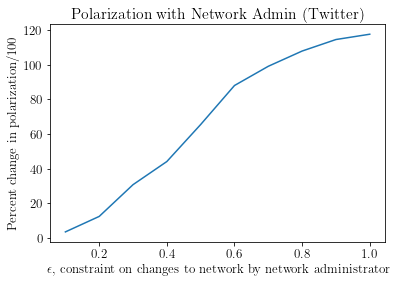

In [24]:
lamvals = sorted(rd_twitter.keys())

pls_ratio_list=np.zeros(len(lamvals))
i=0
for lam in lamvals:
    pls = rd_twitter[lam][0]
    pls_ratio_list[i] = pls[-1] * 1.0 / pls[0]
    i+=1

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 13})

plt.plot(lamvals,pls_ratio_list - 1)
plt.xlabel('$\epsilon$, constraint on changes to network by network administrator')
plt.ylabel('Percent change in polarization/100')
plt.title('Polarization with Network Admin (Twitter)')

plt.savefig(f'{path}/polarization_twitter.png')

# large increase in polarization - though not nearly as large as in Reddit :) 

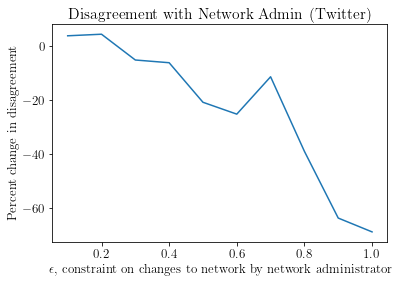

In [25]:
lamvals = sorted(rd_twitter.keys())

disagg_after_list=np.zeros(len(lamvals))
disagg_ratio_list=np.zeros(len(lamvals))
i=0
for lam in lamvals:
    dis = rd_twitter[lam][1]
    disagg_ratio_list[i] = dis[-1] * 1.0 / dis[0]
    disagg_after_list[i] = dis[-1]
    i+=1

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 13})

plt.plot(lamvals,100*(disagg_ratio_list - 1))
plt.xlabel('$\epsilon$, constraint on changes to network by network administrator')
plt.ylabel('Percent change in disagreement')
plt.title('Disagreement with Network Admin (Twitter)')

plt.savefig(f'{path}/disagreement_twitter.png')

# wow, disagreement increases a lot too!

#### Plot polarization, disagreement with regularization

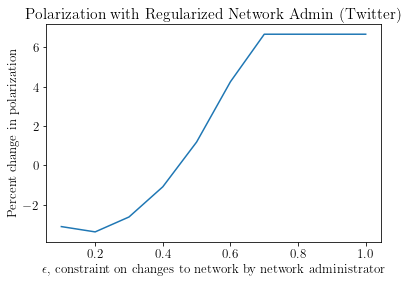

In [26]:
# same plots, but with network fix
lamvals = sorted(rd_twitter_fix.keys())

pls_after_list=np.zeros(len(lamvals))
pls_ratio_list=np.zeros(len(lamvals))
i=0
for lam in lamvals:
    pls = rd_twitter_fix[lam][0]
    pls_ratio_list[i] = pls[-1] * 1.0 / pls[0]
    pls_after_list[i] = pls[-1]
    i+=1

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 13})

plt.plot(lamvals,100*(pls_ratio_list-1))
plt.xlabel('$\epsilon$, constraint on changes to network by network administrator')
plt.ylabel('Percent change in polarization')
plt.title('Polarization with Regularized Network Admin (Twitter)')
    
plt.savefig(f'{path}/polarization_twitter_fix.png')

# polarization is mostly neutral (even slightly dips at lambda=0.2,0.3)


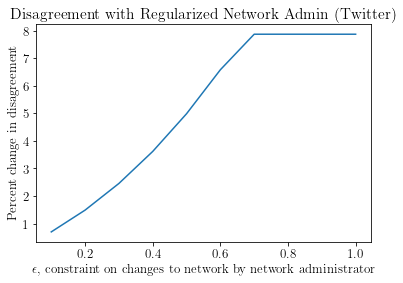

In [27]:
lamvals = sorted(rd_twitter_fix.keys())

disagg_after_list=np.zeros(len(lamvals))
disagg_ratio_list=np.zeros(len(lamvals))
i=0
for lam in lamvals:
    dis = rd_twitter_fix[lam][1]
    disagg_ratio_list[i] = dis[-1] * 1.0 / dis[0]
    disagg_after_list[i] = dis[-1]
    i+=1

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 13})

plt.plot(lamvals,100*(disagg_ratio_list-1))
plt.xlabel('$\epsilon$, constraint on changes to network by network administrator')
plt.ylabel('Percent change in disagreement')
plt.title('Disagreement with Regularized Network Admin (Twitter)')

# fix the y axis from being weird
ax = plt.gca()
ax.get_yaxis().get_major_formatter().set_useOffset(False)

plt.savefig(f'{path}/disagreement_twitter_fix.png')

# okay, so disagreement more-or-less stays the same!